In [1]:
# Import relevant python packages
from datetime import datetime
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
from scipy import stats
from scipy.stats import norm
import warnings
%matplotlib inline

## Exploring Donor Contribution Patterns

In [ ]:
# Load the CSV files into DataFrames 
donors_df = pd.read_csv('donor_base_metrics.csv', header = 0)
transactions_df = pd.read_csv('transactions_cleaned.csv', header = 0)

In [23]:
# Set figure style
sns.set_style("whitegrid")

# Define a color palette to be used in the following visuals 
palette = sns.color_palette("muted")

### Overview of Donation Amounts & Donor Types
>This section explores two key patterns in donor behavior:
>- The distribution of individual donation amounts.
>- The breakdown of one-time versus recurring donors.

In [ ]:
# Initialize figure with 2 subplots 
fig, ax = plt.subplots(1, 2, figsize = (15, 8))

# Log transform donation amounts to capture large value ranges
log_amounts_df = np.log10(transactions_df['amount']).to_frame()

# Compute the median donation amount
donation_med = log_amounts_df['amount'].median()

# Histogram for log-transformed donation amounts
sns.histplot(data = log_amounts_df, x = 'amount', ax = ax[0], color = palette[0], stat = 'density', bins = 20, alpha = 0.4)
sns.kdeplot(data = log_amounts_df, x = 'amount', ax = ax[0], color = palette[1], fill = True, linewidth = 1.5)
ax[0].set_ylabel('Density', fontsize = 16)
ax[0].set_xlabel('Log-Transformed Amount (USD)', fontsize = 16)
ax[0].set_title('Probability Distribution of Donations', fontweight = 'bold', fontsize = 20)
ax[0].annotate(f'Median Donation Amount = ${10**(donation_med)}', 
               xy = (donation_med, 2.0), 
               xytext = (donation_med + 0.3, 2.0), 
               fontweight = 'bold', 
               arrowprops = dict(facecolor = 'black', shrink = 0.05))
ax[0].axvline(x = donation_med, ymax = 0.80, color = palette[1], linestyle = '--', label = 'Donation Median')

# Compute the number of recurring vs one-time donors 
recurring_counts = donors_df['is_recurring'].value_counts().sort_index()

# Pie chart for recurring vs. one-time donors
labels = ['One-Time', 'Recurring']
explode = [0, 0.1]
ax[1].pie(recurring_counts, labels = labels, colors = palette[2:4], explode = explode, autopct = '%.0f%%', textprops = {'fontsize': 16})
ax[1].set_title('Recurring vs One-Time Donors', fontsize = 20, fontweight = 'bold')

fig.tight_layout()
plt.savefig('donation_patterns_updated.png')

>**Distribution of Donation Amounts**
>- The histogram displays the **log-transformed probability distribution of all donation amounts** to account for the skew caused by large gifts.
>- The histogram is overlayed with the correspoding KDE plot, highlighting a **median donation amount of $100**, which also happens to be the **mode, the most frequently occurring amount**. 
>  
>**Recurring vs. One-Time Donors**
>- The pie chart shows that <b>78%</b> of donors have given <b>more than one time</b>.

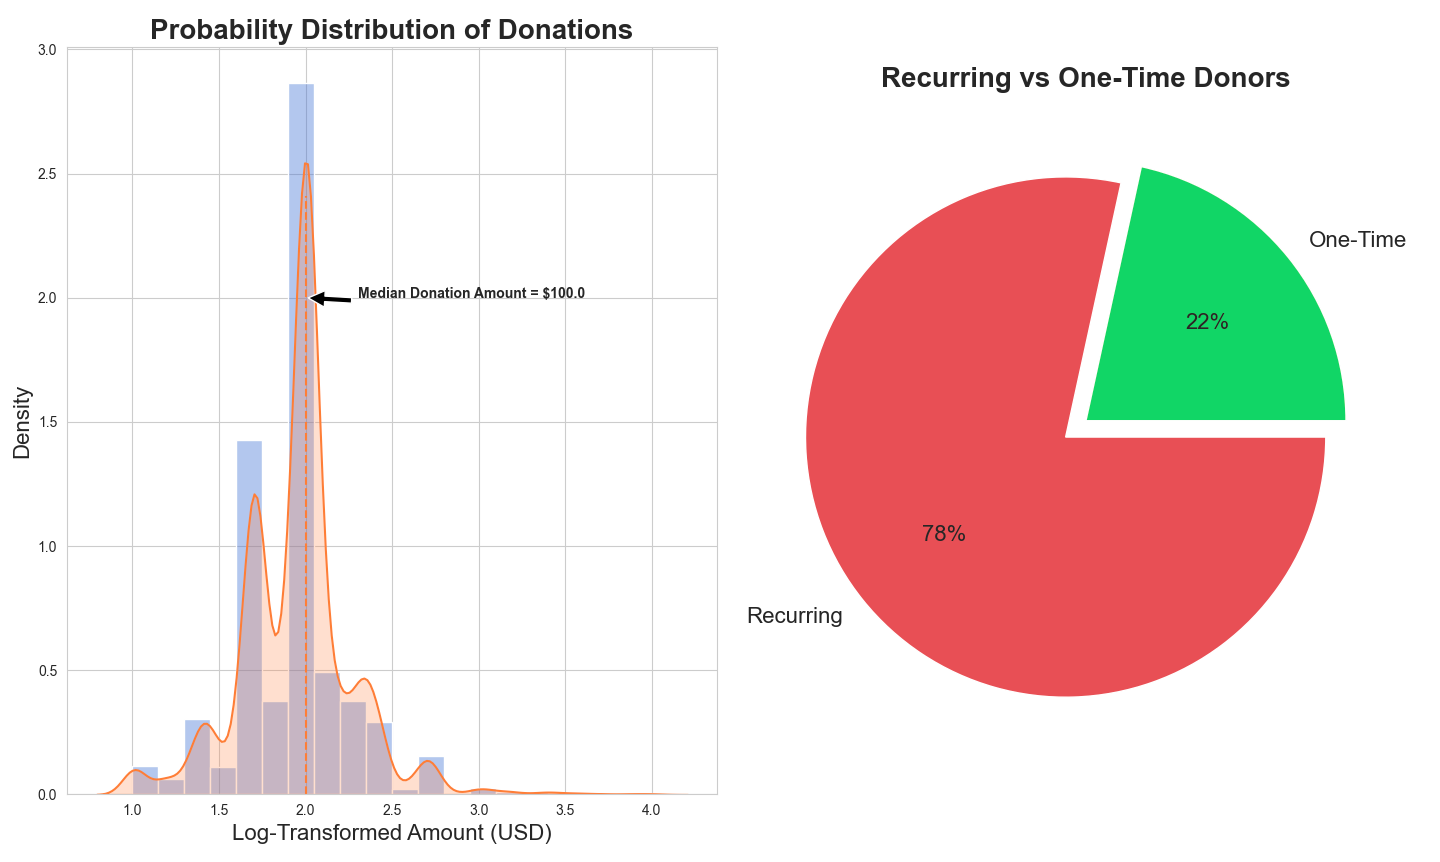

### Top One-Time Donors (By Total Giving)
>This table highlights the **top 10 one-time donors**, ranked by their total donation amount (monetary value).  
>
>To maintain donor privacy, real names have been replaced with anonymous labels (e.g., `donor_0`, `donor_1`, etc.).
>
>These donors contributed significantly despite not giving on a recurring basis which could suggest that they have a **high capacity for giving in one-time events** (e.g., end-of-the-year fundraising campaigns) and may be targeted for future engagement. 

In [32]:
# Filter one-time donors, order by monetary value 
one_time_donors = (
    donors_df.loc[~donors_df['is_recurring'], 
    ['donor_name', 'monetary', 'recency']]
    .sort_values(by = 'monetary', ascending = False)
)

# Assign aliases to donor names to protect privacy
one_time_donors['donor_name'] = one_time_donors.index.map(lambda x: f'donor_{x}')

# Show top 10 one-time donors (according to monetary)
one_time_donors.set_index('donor_name').head(10)

,monetary,recency
donor_name,,
donor_46,10000.0,429
donor_114,7500.0,1188
donor_13,3000.0,102
donor_26,2500.0,1151
donor_104,1500.0,586
donor_48,1200.0,1178
donor_85,1100.0,614
donor_112,1000.0,149
donor_106,750.0,588


### Proportion of Donors with Outlier Donations
>- We first classify **outlier donations** in the transaction dataset using the **IQR method** and a helper function (`iqr_outlier_flags`).
>- Then we calculate the **proportion of donors** who have given **at least one outlier donation**.
>-  Finally, we construct a **95% confidence interval** for this proportion using the normal approximation.

In [24]:
# Function to flag outlier donations within each donor's giving history
def iqr_outlier_flags(amount_series):

    # Compute quartiles & IQR based on donations
    q1 = amount_series.quantile(0.25)
    q3 = amount_series.quantile(0.75)
    iqr = q3 - q1 

    # Outlier detection thresholds
    lower = q1 - (iqr*1.5)
    upper = q3 + (iqr*1.5)
    
    # Return boolean mask for outlier rows
    return (amount_series < lower) | (amount_series > upper)

>- We are **95% confident** that the true proportion of donors who give at least one outlier donation lies **between 0.103 and 0.227**.
>- This means that **if we repeated this sampling process many times**, approximately **95% of the confidence intervals** we construct would **contain the true proportion** of donors with outlier donations.

In [25]:
# Create a per-transaction boolean column showing whether each donation is an outlier
transactions_df['is_outlier'] = (
    transactions_df
    .groupby('donor_name')['amount']
    .transform(iqr_outlier_flags)
)

# Count donors who have at least one outlier donation
num_outlier_donors = (
    transactions_df
    .groupby('donor_name')['is_outlier']
    .any().sum()
)

# Total number of unique donors
num_donors = transactions_df['donor_name'].nunique()

# Sample proportion: probability a donor has an outlier donation
p = num_outlier_donors / num_donors
print(f'Sample proportion of donors with outlier donations: {p:.3%}')

# Check whether or not we can use the normal approximation
if num_donors*p >= 10 and num_donors*(1-p) >= 10:
    print('The distribution of the sample proportion is approximately normal.')

    # Compute the standard error (SE)
    se = np.sqrt(p*(1-p) / num_donors)

    # Compute the z critical value
    # Compute the margin of error (MOE) 
    alpha = 0.05 # 95% confidence
    z = norm.ppf(1-(alpha / 2))
    moe = z*se 
    
    print(f'The 95% confidence interval is {p:.3f} +/- {moe:.3f}')
else:
    print('Normal approximation conditions not met — consider alternative methods.')

Sample proportion of donors with outlier donations: 16.547%
The distribution of the sample proportion is approximately normal.
The 95% confidence interval is 0.165 +/- 0.062


### Monthly Donor Identification & Summary Table
>This section focuses on determining which donors qualify as **monthly givers** and producing a **classification summary**. The workflow includes:
>
>**Computing donation intervals:**
>- Transactions are sorted by donor and date.
>- For each donor, we calculate the **days between consecutive gifts**.
>- We then take the **median of the last three intervals** as a stable estimate of their recent giving cadence.
>
>**Classifying monthly donors:**
>- A donor is labeled monthly if their median interval is **< 35 days**, and they are already marked as **recurring**.
>- This avoids misclassifying recurring donors who give irregularly.
>
>**Generating a classification summary table:**
>- **Recurring Monthly** — recurring donors who give approximately monthly
>- **Recurring Not Monthly** — recurring donors with irregular intervals
>- **One Time** — donors who have given only once or are not recurring
>- **Totals** — total number of donors evaluated

In [ ]:
donors_df = donors_df.merge(
    # Work with transactions sorted by donor and date so diff() gives correct intervals
    transactions_df
        .sort_values(by = ['donor_name', 'date'], ascending = True)
        # .assign creates a NEW column and returns a new DataFrame (doesn't modify in-place)
        # Syntax: .assign(new_col=lambda df: ... ) where the df inside lambda
        # refers to the DataFrame after the sort_values above.
        # Here we compute days between consecutive donations per donor
        .assign(days_since_prev = lambda df: df.groupby('donor_name')['date'].diff().dt.days)
        # Aggregate each donor to a single row by taking median donation gap over the last 3 donations
        .groupby('donor_name')['days_since_prev'].apply(lambda x: x.tail(3).median())
        .rename('median_recent_interval'),
    how = 'left', on = 'donor_name')

# Donor is considered "monthly" if:
# - Their median donation interval is less than 35 days
# - AND we already flagged them as recurring supporters
# - .lt() is "less than" method in pandas
donors_df['is_monthly'] = (donors_df['median_recent_interval'].lt(35) & donors_df['is_recurring'])

In [25]:
# Build a summary table of donor segmentation and counts
summary = pd.DataFrame({
    'Category': [
        'Recurring Monthly',  # Recurring donors who give approx monthly (<35 day median interval)
        'Recurring Not Monthly', # Recurring donors who donate but not on a monthly consistency
        'One Time', # Donors with no recurring history
        'Totals' # Total donor count
    ],
    'Counts': [
        #Count monthly supporters (True = 1 when summed)
        (donors_df['is_monthly']).sum(),
        
        # Recurring donors that are NOT monthly:
        # must be recurring AND not monthly
        (donors_df['is_recurring'] & ~donors_df['is_monthly']).sum(),

        # Non-recurring donors (one-timers)
        (~donors_df['is_recurring']).sum(),
        
        # Total donors, counting rows in donors_df
        (donors_df['donor_name']).count()
    ]
# Make category names the index so the table is clean and readable
}).set_index('Category')

summary # Display the final summary table

,Counts
Category,
Recurring Monthly,103
Recurring Not Monthly,6
One Time,30
Totals,139


>- Each of these donor categories exhibits **distinct giving behaviors** and will therefore be **treated separately during segmentation**.
>- **One-time donors** and **non-monthly recurring donors** will be assigned to dedicated **segments**: `one_time` and `rec_not_monthly`.
>- More detailed analysis, such as feature binning and RFM scoring, is **applied exclusively to monthly donors**, where additional **sub-segments** are created.

### Distribution of Recency, Frequency, and Monetary (RFM) Value
>In this section, we visualize the distribution of the three key RFM (**Recency, Frequency, Monetary**) features using box plots for **monthly donors**.
>
> This helps us:
>- Understand the **range** and **central tendency** of each feature.
>- Identify the presence of **outliers**.
>- Assess the **skewness** of each distribution. 

In [ ]:
# Initialize figure with 3 subplots 
fig, ax = plt.subplots(1, 3, figsize = (15, 8))

# Filter for monthly donors
monthly_donors_df = donors_df.loc[donors_df['is_monthly'], :]

# Define RFM features
rfm_features = ['recency', 'frequency', 'monetary']

# Box plots for RFM features
fig.suptitle('Distribution of RFM Value', fontsize = 20, fontweight = 'bold')
for i, feat in enumerate(rfm_features):
	sns.boxplot(
        y = monthly_donors_df[feat], showfliers = True, ax = ax[i], width = 0.7, 
        color = palette[i], flierprops = {'mfc' : 'black', 'marker': 'D'}
    )
	ax[i].set_ylabel(feat, fontsize = 16)

fig.tight_layout()
plt.savefig('rfm_features_box_updated.png')

>**RFM Distributions**
>
>- **Recency**: The median, lower quartile, and minimum are all very close together despite a wide, overall range. This suggests that most donors have given recently while few donors have not given in a long time. In particular, **the majority of monthly donors remain fully engaged**, while a smaller portion have lapsed or fully churned.
>- **Frequency**: The interquartile range shows that **the middle 50% of monthly donors** have given somewhere **between 15 and 35 donations**, while the median indicates that most donors within this group fall toward the higher end of that range.
>- **Monetary**: While the distribution is **largely symmetric**, with a **median around $2,000**, a small number of extreme outliers indicate the presence of exceptionally generous monthly donors.

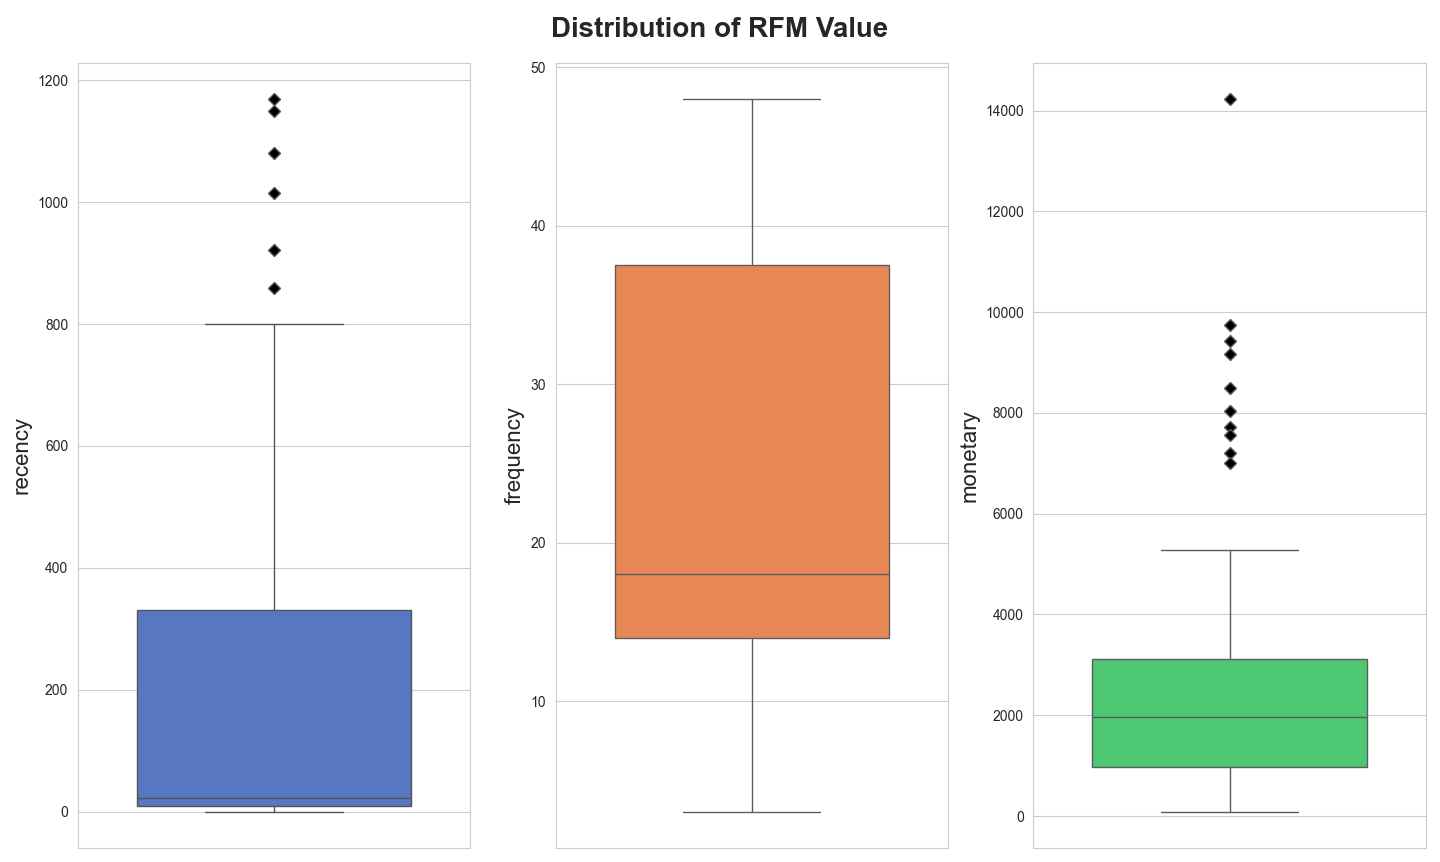

### State-by-State Analysis of Donation Totals & Donor Numbers
>To understand the geographic distribution of giving behavior, we conducted a **state-level analysis** of donor contributions which shows:
>- The **total donation amount** contributed by donors in each state.
>- The **number of individual donors** per state, offering insight into regional donor concentration. 
>
> These findings are especially useful for strategic planning. Since we travel to the U.S. once a year for in-person donor engagement and fundraising, this data helps us **prioritize which states or regions to focus our efforts on**, maximizing relational and fundraising impact.


In [ ]:
# Initialize figure with two subplots 
fig, ax = plt.subplots(1, 2, figsize = (15,8))

# ---- Compute State-Level Donation Totals ----
# Merge donor state info into the transaction dataset,
# group by state, then compute total donation amount per state
donation_totals_by_state = (
	pd.merge(
		transactions_df, 
		donors_df[['donor_name', 'state']], 
    	how = 'left', 
    	on = 'donor_name')
	.groupby('state', as_index = False)
	.agg({'amount' : 'sum'})
	.sort_values(by = 'amount', ascending = False)
	.reset_index(drop = True)
)

# ---- Compute Donor Counts by State ----
# Group donors by state and count unique donor names
donor_counts_by_state = (
	donors_df.groupby('state', as_index = False)
	.agg(**{'donor_counts': ('donor_name', 'count')})
	.sort_values(by = 'donor_counts', ascending = False)
	.reset_index(drop = True)
)

# Bar plot for total donations by state 
ax[0].bar(donation_totals_by_state['state'], donation_totals_by_state['amount'], color = palette)
ax[0].set_xticks(ticks = range(len(donation_totals_by_state)), labels = donation_totals_by_state['state'], rotation = 45)
ax[0].set_ylabel('Amount (USD)', fontsize = 16)
ax[0].set_xlabel('State', fontsize = 16)
ax[0].set_title('Total Donations By State', fontweight = 'bold', fontsize = 20)

# Bar plot for number of donors per state
ax[1].bar(donor_counts_by_state['state'], donor_counts_by_state['donor_counts'], color = palette)
ax[1].set_xticks(ticks = range(len(donor_counts_by_state)), labels = donor_counts_by_state['state'], rotation = 45)
ax[1].set_ylabel('Number of Donors', fontsize = 16)
ax[1].set_xlabel('State', fontsize = 16)
ax[1].set_title('Number of Donors Per State', fontweight = 'bold', fontsize = 20)

plt.savefig('state_by_state_bar_updated.png')

> **Total Donations By State**
> - The bar plot reveals that donors in **Arizona** contribute the **largest share of total donations**, with **Texas** following as the **second-highest**.
>
> **Number of Donors per State**
> - The bar plot indicates that **donor count is highest in Arizona**, with **Texas** having the **second-largest donor base**.
>
> Donor counts and total donations are highest in Arizona and Texas, suggesting these states may offer the strongest  opportunities for **in-person engagement and fundraising**.

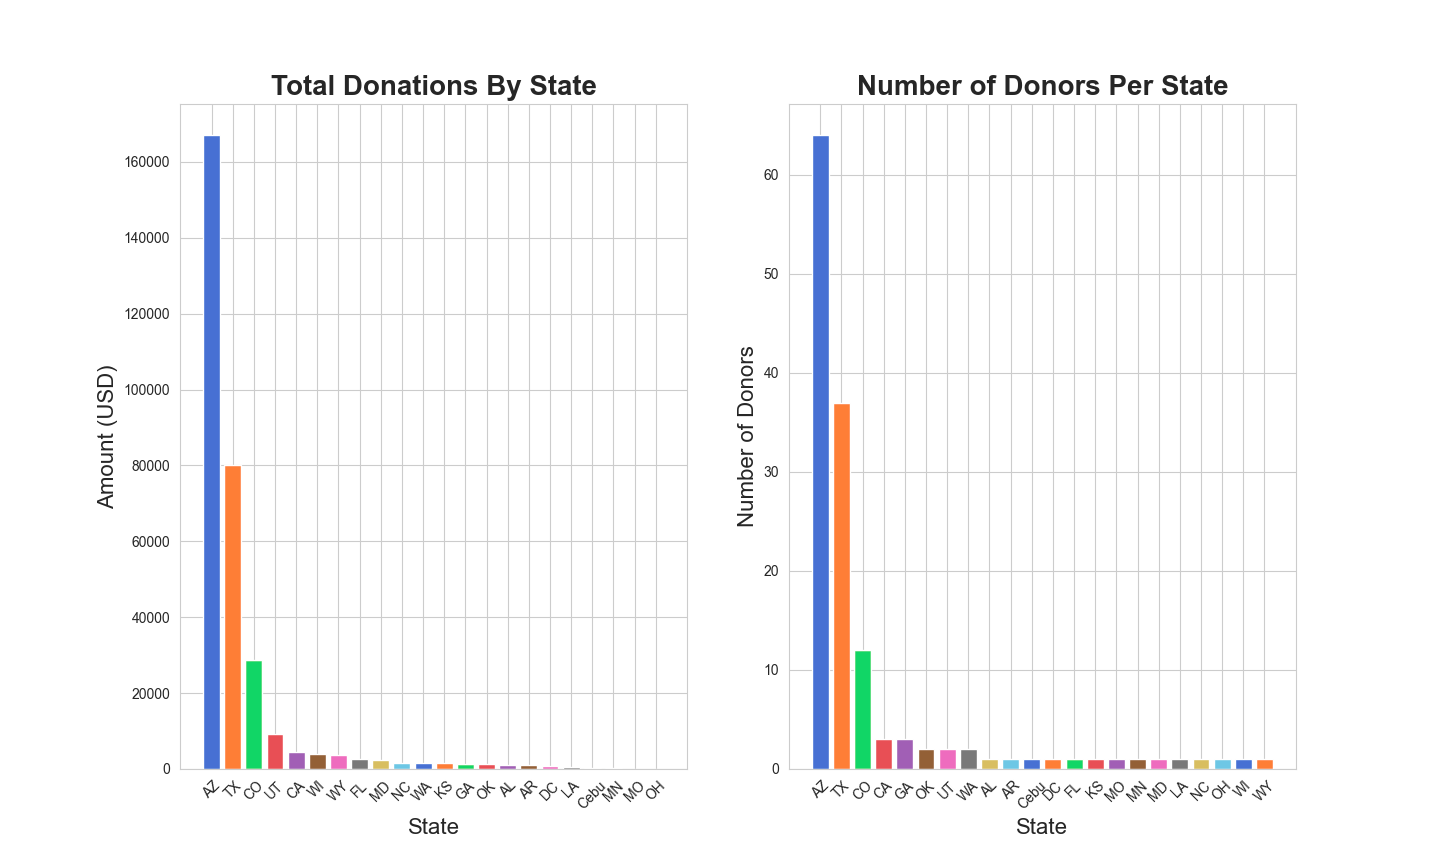

In [10]:
# Save the processed DataFrames to CSV files for downline analysis
donors_df.to_csv('donor_behavioral_features.csv', index = False)
transactions_df.to_csv('transactions_processed.csv', index = False)